In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn import preprocessing as prep
import pickle

import pathlib
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17645806310100111968
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17377638192647558037
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9659331356618461057
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 13816878848
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3765321932748630827
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [ ]:
tf.device('cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dftr = pd.read_csv('/content/drive/MyDrive/fluent_speech_commands_dataset/data/train_data.csv',index_col=0)
dftr.head(1)

,path,speakerId,transcription,action,object,location
0,wavs/speakers/2BqVo8kVB2Skwgyb/0a3129c0-4474-1...,2BqVo8kVB2Skwgyb,Change language,change language,none,none


In [ ]:
dfts = pd.read_csv('/content/drive/MyDrive/fluent_speech_commands_dataset/data/test_data.csv',index_col=0)
dfts.head(1)

,path,speakerId,transcription,action,object,location
0,wavs/speakers/4BrX8aDqK2cLZRYl/cbdf5700-452c-1...,4BrX8aDqK2cLZRYl,Turn on the lights,activate,lights,none


In [ ]:
dfval = pd.read_csv('/content/drive/MyDrive/fluent_speech_commands_dataset/data/valid_data.csv',index_col=0)
dfval.head(1)

,path,speakerId,transcription,action,object,location
0,wavs/speakers/7NqqnAOPVVSKnxyv/8b863c90-4627-1...,7NqqnAOPVVSKnxyv,Turn on the lights,activate,lights,none


In [ ]:
names=np.array(dftr['action']+' '+dftr['object']+' '+dftr['location'])
names=names.T
print(names.shape)
print(names[0:5])

(23132,)
['change language none none' 'activate music none' 'activate lights none'
 'activate lights none' 'deactivate lights none']


In [ ]:
names_ts=np.array(dfts['action']+' '+dfts['object']+' '+dfts['location'])
names_ts=names_ts.T
print(names_ts.shape)
print(names_ts[0:5])

(3793,)
['activate lights none' 'deactivate lights none'
 'change language none none' 'deactivate music none' 'activate music none']


In [ ]:
names_val=np.array(dfval['action']+' '+dfval['object']+' '+dfval['location'])
names_val=names_val.T
print(names_val.shape)
print(names_val[0:5])

(3118,)
['activate lights none' 'deactivate lights none'
 'change language none none' 'deactivate music none' 'activate music none']


In [ ]:
le = prep.LabelEncoder()
ytr = le.fit_transform(names)
num_labels = np.max(ytr)+1
print(num_labels)
labels = le.classes_


31


In [ ]:
yts = le.transform(names_ts)
yval = le.transform(names_val)

In [ ]:
rand_sample = [15,43]
#print(labels)
print(names[rand_sample])
print(ytr[rand_sample])
print(labels[ytr[rand_sample]])

['deactivate music none' 'activate lights washroom']
[20  4]
['deactivate music none' 'activate lights washroom']


In [ ]:
print(names_ts[rand_sample])
print(yts[rand_sample])
print(labels[yts[rand_sample]])

['increase volume none' 'activate lights kitchen']
[30  2]
['increase volume none' 'activate lights kitchen']


In [ ]:
print(names_val[rand_sample])
print(yval[rand_sample])
print(labels[yval[rand_sample]])

['increase volume none' 'activate lights kitchen']
[30  2]
['increase volume none' 'activate lights kitchen']


In [ ]:
Xtr_path = '/content/drive/MyDrive/fluent_speech_commands_dataset/'+dftr['path']
Xtr_path = tf.convert_to_tensor(Xtr_path)
print(Xtr_path.shape)
print(Xtr_path[0:5])

(23132,)
tf.Tensor(
[b'/content/drive/MyDrive/fluent_speech_commands_dataset/wavs/speakers/2BqVo8kVB2Skwgyb/0a3129c0-4474-11e9-a9a5-5dbec3b8816a.wav'
 b'/content/drive/MyDrive/fluent_speech_commands_dataset/wavs/speakers/2BqVo8kVB2Skwgyb/0ee42a80-4474-11e9-a9a5-5dbec3b8816a.wav'
 b'/content/drive/MyDrive/fluent_speech_commands_dataset/wavs/speakers/2BqVo8kVB2Skwgyb/144d5be0-4474-11e9-a9a5-5dbec3b8816a.wav'
 b'/content/drive/MyDrive/fluent_speech_commands_dataset/wavs/speakers/2BqVo8kVB2Skwgyb/1811b6e0-4474-11e9-a9a5-5dbec3b8816a.wav'
 b'/content/drive/MyDrive/fluent_speech_commands_dataset/wavs/speakers/2BqVo8kVB2Skwgyb/1d9f3920-4474-11e9-a9a5-5dbec3b8816a.wav'], shape=(5,), dtype=string)


In [ ]:
Xts_path = '/content/drive/MyDrive/fluent_speech_commands_dataset/'+dfts['path']
Xts_path = tf.convert_to_tensor(Xts_path)
print(Xts_path.shape)
print(Xts_path[0:5])

(3793,)
tf.Tensor(
[b'/content/drive/MyDrive/fluent_speech_commands_dataset/wavs/speakers/4BrX8aDqK2cLZRYl/cbdf5700-452c-11e9-b1e4-e5985dca719e.wav'
 b'/content/drive/MyDrive/fluent_speech_commands_dataset/wavs/speakers/4BrX8aDqK2cLZRYl/cff92500-452c-11e9-b1e4-e5985dca719e.wav'
 b'/content/drive/MyDrive/fluent_speech_commands_dataset/wavs/speakers/4BrX8aDqK2cLZRYl/d36722a0-452c-11e9-b1e4-e5985dca719e.wav'
 b'/content/drive/MyDrive/fluent_speech_commands_dataset/wavs/speakers/4BrX8aDqK2cLZRYl/d73086b0-452c-11e9-b1e4-e5985dca719e.wav'
 b'/content/drive/MyDrive/fluent_speech_commands_dataset/wavs/speakers/4BrX8aDqK2cLZRYl/da54f830-452c-11e9-b1e4-e5985dca719e.wav'], shape=(5,), dtype=string)


In [ ]:
Xval_path = '/content/drive/MyDrive/fluent_speech_commands_dataset/'+dfval['path']
Xval_path = tf.convert_to_tensor(Xval_path)
print(Xval_path.shape)
print(Xval_path[0:5])

(3118,)
tf.Tensor(
[b'/content/drive/MyDrive/fluent_speech_commands_dataset/wavs/speakers/7NqqnAOPVVSKnxyv/8b863c90-4627-11e9-bc65-55b32b211b66.wav'
 b'/content/drive/MyDrive/fluent_speech_commands_dataset/wavs/speakers/7NqqnAOPVVSKnxyv/8d8f7a10-4627-11e9-bc65-55b32b211b66.wav'
 b'/content/drive/MyDrive/fluent_speech_commands_dataset/wavs/speakers/7NqqnAOPVVSKnxyv/8f7773f0-4627-11e9-bc65-55b32b211b66.wav'
 b'/content/drive/MyDrive/fluent_speech_commands_dataset/wavs/speakers/7NqqnAOPVVSKnxyv/916cb440-4627-11e9-bc65-55b32b211b66.wav'
 b'/content/drive/MyDrive/fluent_speech_commands_dataset/wavs/speakers/7NqqnAOPVVSKnxyv/934321f0-4627-11e9-bc65-55b32b211b66.wav'], shape=(5,), dtype=string)


In [ ]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [ ]:
def get_waveform(file_path,labs):
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform,labs

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices((Xtr_path[:7000],ytr[:7000]))
waveform_ds = files_ds.map(get_waveform, num_parallel_calls=AUTOTUNE)

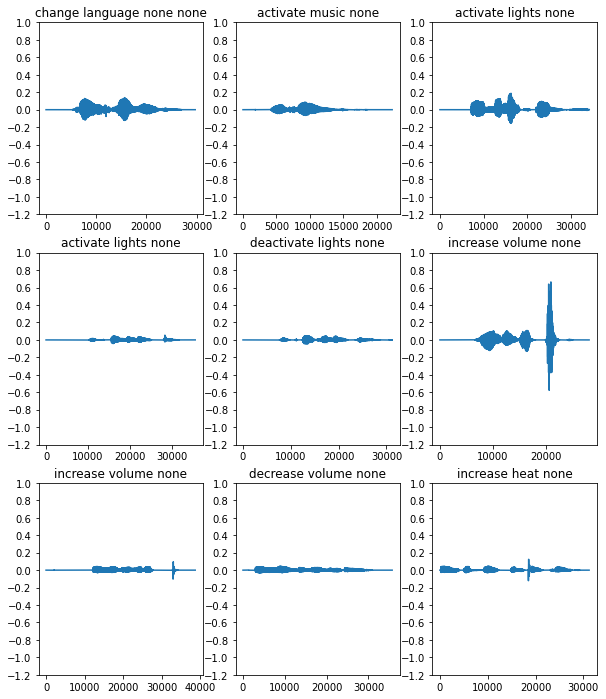

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio,cl) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  ax.set_title(labels[cl])

In [ ]:
def get_spectrogram(waveform,lab):
  num_samples, sample_rate = int(16000*10), 16000.0
  # Padding for files with less than 16000*10 samples
  zero_padding = tf.zeros([num_samples] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=512, frame_step=256)

  spectrogram = tf.abs(spectrogram)

  #Convert Spectrogram to Mel-scale Spectrogram
  num_spectrogram_bins = spectrogram.shape[-1]
  lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 7600.0, 257
  linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz,
    upper_edge_hertz)
  mel_spectrogram = tf.tensordot(
    spectrogram, linear_to_mel_weight_matrix, 1)
  mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(
    linear_to_mel_weight_matrix.shape[-1:]))

  # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
  log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
  spectrograms = tf.convert_to_tensor((spectrogram, mel_spectrogram, log_mel_spectrogram))
  spectrograms = tf.transpose(spectrograms,perm=[1,2,0])
  return spectrograms, lab

In [ ]:
for waveform,cl in waveform_ds.take(1):
  spectrograms, label = get_spectrogram(waveform, cl)
spectrograms = tf.transpose(spectrograms,perm=[2,0,1])
print(spectrograms.shape)
print('Label:', labels[label])
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrograms[0].shape)
print('Mel Spectrogram shape:', spectrograms[1].shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

(3, 624, 257)
Label: change language none none
Waveform shape: (29722,)
Spectrogram shape: (624, 257)
Mel Spectrogram shape: (624, 257)
Audio playback


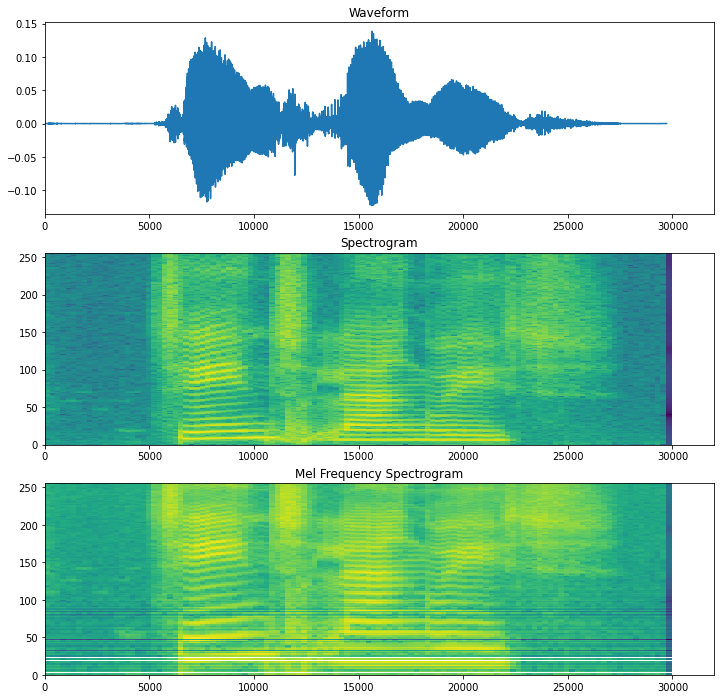

In [ ]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  X = np.arange(int(16000*10), step=height-1)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(3, figsize=(12, 12))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000*2])
plot_spectrogram(spectrograms[0].numpy(), axes[1])
axes[1].set_title('Spectrogram')
axes[1].set_xlim([0, 16000*2])
plot_spectrogram(spectrograms[1].numpy(), axes[2])
axes[2].set_title('Mel Frequency Spectrogram')
axes[2].set_xlim([0, 16000*2])
plt.show()

In [ ]:
spectrogram_ds = waveform_ds.map(get_spectrogram, num_parallel_calls=AUTOTUNE)
spectrogram_ds = spectrogram_ds.take(-1)

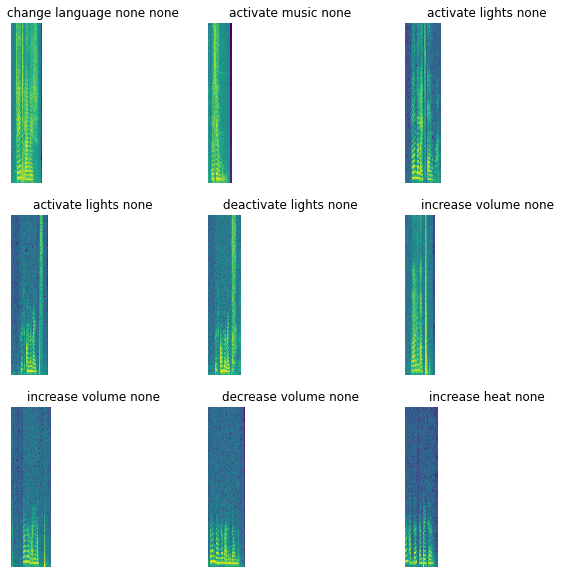

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram,label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  spectrogram = tf.transpose(spectrogram,perm=[2,0,1])
  plot_spectrogram(np.squeeze(spectrogram[0].numpy()), ax)
  ax.set_title(labels[label_id.numpy()])
  ax.axis('off')

plt.show()

In [ ]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(get_spectrogram,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [ ]:

train_ds = spectrogram_ds
val_ds = preprocess_dataset((Xval_path,yval))
test_ds = preprocess_dataset((Xts_path,yts))

In [ ]:
batch_size = 50 #map function used to create train_ds overflows above 65
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [ ]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [ ]:
def spec_only(spec,lab):
  
  return spec

for spec, lab in spectrogram_ds.take(1):
  spectrograms = spec_only(spec,lab)
  input_shape = spectrograms.shape
print('Input shape:', input_shape)
print(len(labels))



Input shape: (624, 257, 3)
31


In [ ]:
for spec, lab in train_ds.take(1):
  tr_shape = spec.shape
  ytr_shape = lab.shape
print('(batch_sz,nrow,ncol,chan)',tr_shape)
print('(batch_sz,)',ytr_shape)

(batch_sz,nrow,ncol,chan) (50, 624, 257, 3)
(batch_sz,) (50,)


In [ ]:
#norm_layer = preprocessing.Normalization()
#norm_ds = spectrogram_ds.map(spec_only,num_parallel_calls=AUTOTUNE)
#norm_layer.adapt(norm_ds)
###norm_layer.adapt(spectrogram_ds.map(spec_only,num_parallel_calls=AUTOTUNE))

In [ ]:
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense

In [ ]:
import tensorflow.keras.backend as K
K.clear_session()

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import decode_predictions, preprocess_input  
base_model = applications.VGG19(include_top=False, weights='imagenet', input_shape = input_shape)

In [ ]:
model = Sequential()#[layers.Input(shape=input_shape), norm_layer])

#Loop over base_model.layers and add each layer to model
for layer in base_model.layers:
  model.add(layer)

for layer in model.layers:
  layer.trainable = False

In [ ]:
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(num_labels))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 624, 257, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 624, 257, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 312, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 312, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 312, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 156, 64, 128)      0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 156, 64, 256)      2

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
steps_per_epoch = Xtr_path.shape[0]//batch_size
validation_steps = Xval_path.shape[0]//batch_size
print(f'Steps per epoch = {steps_per_epoch}')
print(f'Validadtion Steps = {validation_steps}')

Steps per epoch = 462
Validadtion Steps = 62


In [ ]:
EPOCHS = 5
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    #validation_steps=validation_steps,
    #steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
)

Epoch 1/5
 39/140 [=======>......................] - ETA: 1:54 - loss: 4.9179 - accuracy: 0.0467

####**Dataset.map()** method has led to this program not being able to run. 

#####This is due to the entire training spectrogram dataset being loaded into RAM during traing which quickly leads to crashes.Thus Another way of data generation must be devised.

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()